In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [13]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 
import matplotlib.cm as cm


import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM
from scipy import linalg

In [6]:
Trials = 10
for unitary_seed in range(Trials):
    #initial_pops = [0.043407, 0.12, 0.09, 0.15, 0.3,0.14, 0.23, 0.026593]
    initial_pops = [1,0,0,0,1,0,0,1]
    #initial_pops = [0.1,0.1,0.1,0.1,0.4,0.1,0.1,0.1]
    system = DM.n_thermal_qbits(initial_pops)
    connectivity = "c2_2local"
    unitary_energy_subspace = 1
    ordering_seed = 1
    chunk_size = 2
    order_rule_name = "random"
    num_steps = 10
    data = cleo.execute(file_name="random",
                       connectivity=connectivity,
                       order_rule_name = order_rule_name, 
                       unitary_seed=unitary_seed,
                       unitary_energy_subspace=unitary_energy_subspace,
                       evolution_generator_type="haar2Qunitary",
                       chunk_size=chunk_size,
                       num_steps=num_steps,
                       initial_pops=initial_pops,
                       verbosity = .9);

simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c2_2local_connectivity-unitary_energy_subspace_1-unitary_seed

In [8]:
hdf5merge.merge_hdf5_files("../data/random")
newdata1 = dict(h5py.File("../data/random/random.hdf5"))

In [9]:
def get_pops(data, n_qubits, connectivity, update_rule):
    """Extract population data from HDF5 file - works the same as before"""
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return np.array(result)

def get_2_qbit_dms(data, n_qubits, connectivity, update_rule):
    """Extract two-qubit density matrices from HDF5 file - works the same as before"""
    basis = ket.canonical_basis(2)
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)
    
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return np.array(result)

def get_3_qbit_dms(data, n_qubits, connectivity, update_rule):
    """Extract three-qubit density matrices from HDF5 file - only for last 5 steps"""
    basis = ket.canonical_basis(3)
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)
    
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        try:
            dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['three_qubit_dms'])
            dat = {int(k.split('(')[0]): dat[k] for k in dat}
            
            # Convert to density matrices
            dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
            result.append(dat)
        except KeyError:
            print(f"Warning: No three-qubit density matrices found for trial with seed {seed}")
            # Append an empty array or None to keep the result structure consistent
            result.append(None)
    
    return np.array(result, dtype=object)

def get_4_qbit_dms(data, n_qubits, connectivity, update_rule):
    """Extract four-qubit density matrices from HDF5 file - only for last 5 steps"""
    basis = ket.canonical_basis(4)
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)
    
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        try:
            dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['four_qubit_dms'])
            dat = {int(k.split('(')[0]): dat[k] for k in dat}
            
            # Convert to density matrices
            dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
            result.append(dat)
        except KeyError:
            print(f"Warning: No four-qubit density matrices found for trial with seed {seed}")
            # Append an empty array or None to keep the result structure consistent
            result.append(None)
    
    return np.array(result, dtype=object)

def get_5_qbit_dms(data, n_qubits, connectivity, update_rule):
    """Extract five-qubit density matrices from HDF5 file - only for last 5 steps"""
    basis = ket.canonical_basis(5)
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)
    
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        try:
            dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['five_qubit_dms'])
            dat = {int(k.split('(')[0]): dat[k] for k in dat}
            
            # Convert to density matrices
            dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
            result.append(dat)
        except KeyError:
            print(f"Warning: No five-qubit density matrices found for trial with seed {seed}")
            # Append an empty array or None to keep the result structure consistent
            result.append(None)
    
    return np.array(result, dtype=object)

def get_6_qbit_dms(data, n_qubits, connectivity, update_rule):
    """Extract six-qubit density matrices from HDF5 file - only for last 5 steps"""
    basis = ket.canonical_basis(6)
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)
    
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        try:
            dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['six_qubit_dms'])
            dat = {int(k.split('(')[0]): dat[k] for k in dat}
            
            # Convert to density matrices
            dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
            result.append(dat)
        except KeyError:
            print(f"Warning: No six-qubit density matrices found for trial with seed {seed}")
            # Append an empty array or None to keep the result structure consistent
            result.append(None)
    
    return np.array(result, dtype=object)

In [11]:
threedms = get_3_qbit_dms(newdata1,8,"c2_2local","random")
threedms[0][0]

{(0, 1, 2): DM 5078353712,
 (0, 1, 3): DM 5078363872,
 (0, 1, 4): DM 5078353392,
 (0, 1, 5): DM 5078365552,
 (0, 1, 6): DM 5078353792,
 (0, 1, 7): DM 5078353472,
 (0, 2, 3): DM 5078353312,
 (0, 2, 4): DM 5078353152,
 (0, 2, 5): DM 5078352992,
 (0, 2, 6): DM 5078352832,
 (0, 2, 7): DM 5078354352,
 (0, 3, 4): DM 5078355632,
 (0, 3, 5): DM 5078355552,
 (0, 3, 6): DM 5078352672,
 (0, 3, 7): DM 5078353632,
 (0, 4, 5): DM 5080403472,
 (0, 4, 6): DM 5078205696,
 (0, 4, 7): DM 5078205296,
 (0, 5, 6): DM 5078205216,
 (0, 5, 7): DM 5078205376,
 (0, 6, 7): DM 5078205056,
 (1, 2, 3): DM 5078212816,
 (1, 2, 4): DM 5078212016,
 (1, 2, 5): DM 5078218976,
 (1, 2, 6): DM 5078218736,
 (1, 2, 7): DM 5078218496,
 (1, 3, 4): DM 5078218256,
 (1, 3, 5): DM 5078218016,
 (1, 3, 6): DM 5078217776,
 (1, 3, 7): DM 5078217536,
 (1, 4, 5): DM 5078217296,
 (1, 4, 6): DM 5078217056,
 (1, 4, 7): DM 5078216816,
 (1, 5, 6): DM 5078216576,
 (1, 5, 7): DM 5078216336,
 (1, 6, 7): DM 5078215856,
 (2, 3, 4): DM 5078216096,
 

Processing step 1/5
No data available for 1-qubit subsystems
Processing step 2/5
No data available for 1-qubit subsystems
Processing step 3/5
No data available for 1-qubit subsystems
Processing step 4/5
No data available for 1-qubit subsystems
Processing step 5/5
No data available for 1-qubit subsystems


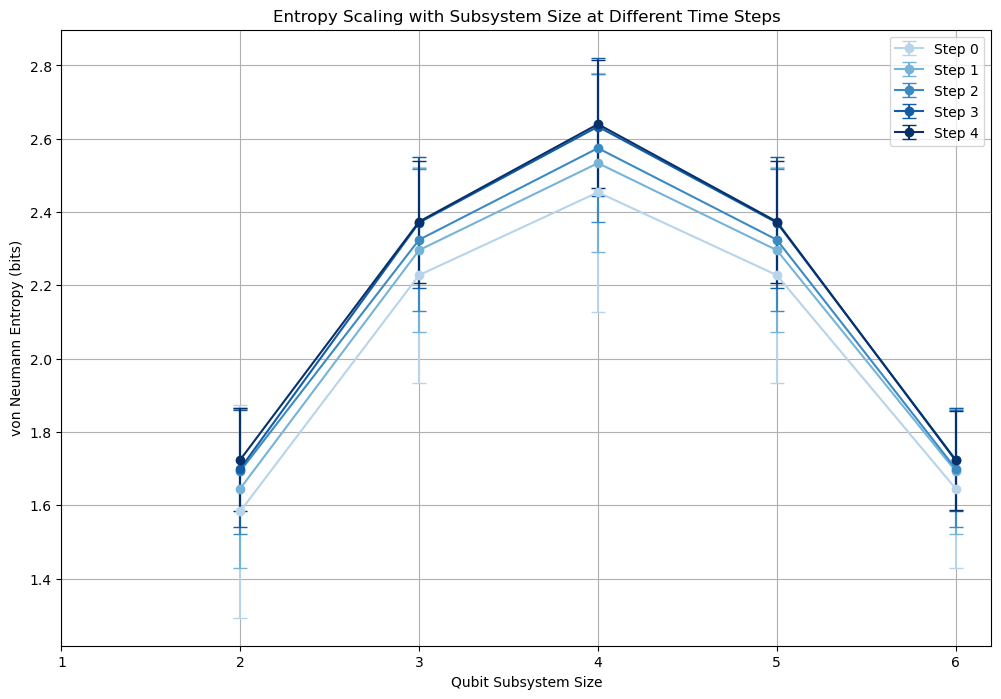

Entropy Results by Size and Step:
Size | Step 0 Mean±Std | Step 1 Mean±Std | Step 2 Mean±Std | Step 3 Mean±Std | Step 4 Mean±Std
------------------------------------------------------------------------------------------------------
   1 | N/A | N/A | N/A | N/A | N/A
   2 | 1.5837±0.2904 | 1.6458±0.2163 | 1.6935±0.1716 | 1.7001±0.1596 | 1.7244±0.1403
   3 | 2.2280±0.2945 | 2.2961±0.2228 | 2.3245±0.1934 | 2.3711±0.1780 | 2.3739±0.1666
   4 | 2.4539±0.3253 | 2.5335±0.2428 | 2.5744±0.2022 | 2.6330±0.1881 | 2.6398±0.1738
   5 | 2.2280±0.2945 | 2.2961±0.2228 | 2.3245±0.1934 | 2.3711±0.1780 | 2.3739±0.1666
   6 | 1.6458±0.2163 | 1.6935±0.1716 | 1.7001±0.1596 | 1.7245±0.1403 | 1.7223±0.1339


In [17]:
def von_neumann_entropy(rho):
    """
    Calculate the von Neumann entropy S = -Tr(rho log(rho)) for a density matrix.
    
    Args:
        rho: A numpy array representing a density matrix
        
    Returns:
        The von Neumann entropy as a real number
    """
    # Get the eigenvalues of the density matrix
    eigenvalues = linalg.eigvalsh(rho)
    
    # Remove very small eigenvalues that might cause numerical issues
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    
    # Calculate entropy: -sum(λ_i * log(λ_i))
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def calculate_entropy_for_size(dms, trial_idx, step_idx, size):
    """
    Calculate entropies for all subsystems of a specific size in a given trial and step.
    
    Args:
        dms: Dictionary of density matrices (key: qubit_size -> trial_idx -> step_idx -> subsystem_tuple)
        trial_idx: Trial index
        step_idx: Step index
        size: Qubit subsystem size
        
    Returns:
        List of entropy values for all subsystems of the specified size
    """
    if size not in dms:
        return []
    
    try:
        subsystems = dms[size][trial_idx][step_idx]
        entropies = []
        
        for qubits, dm in subsystems.items():
            # Convert DM to numpy array
            dm_array = dm.data.toarray()
            
            # Calculate entropy
            try:
                entropy = von_neumann_entropy(dm_array)
                entropies.append(entropy)
            except Exception as e:
                print(f"Error calculating entropy for size {size}, qubits {qubits} at step {step_idx}: {e}")
        
        return entropies
    except (KeyError, IndexError) as e:
        print(f"Error accessing data for size {size}, trial {trial_idx}, step {step_idx}: {e}")
        return []

def analyze_entropy_across_sizes(dms_dict, num_trials, num_steps=5, max_size=8):
    """
    Calculate entropy statistics across different qubit subsystem sizes.
    
    Args:
        dms_dict: Dictionary of density matrices by size 
                 (e.g., {1: onedms, 2: twodms, 3: threedms, ...})
        num_trials: Number of trials
        num_steps: Number of steps to analyze
        max_size: Maximum qubit subsystem size
        
    Returns:
        Dictionary with structure: {step_idx: {size: (mean_entropy, std_entropy)}}
    """
    # Initialize results dictionary
    results = {step: {} for step in range(num_steps)}
    
    # Process each step
    for step_idx in range(num_steps):
        print(f"Processing step {step_idx+1}/{num_steps}")
        
        # Process each qubit subsystem size
        for size in range(1, max_size + 1):
            if size not in dms_dict:
                print(f"No data available for {size}-qubit subsystems")
                continue
                
            # Collect entropies across all trials for this step and size
            all_entropies = []
            
            for trial_idx in range(num_trials):
                entropies = calculate_entropy_for_size(dms_dict, trial_idx, step_idx, size)
                all_entropies.extend(entropies)
            
            # Calculate statistics if we have data
            if all_entropies:
                mean_entropy = np.mean(all_entropies)
                std_entropy = np.std(all_entropies)
                results[step_idx][size] = (mean_entropy, std_entropy)
            else:
                print(f"No entropy data for {size}-qubit subsystems at step {step_idx}")
    
    return results

def plot_entropy_by_size_and_step(entropy_results, num_steps=5, max_size=8,col="random"):
    """
    Plot entropy vs. subsystem size with different lines for each step.
    
    Args:
        entropy_results: Results from analyze_entropy_across_sizes
        num_steps: Number of steps that were analyzed
        max_size: Maximum qubit subsystem size
    """
    plt.figure(figsize=(12, 8))
    
    # Create a color map with different shades of blue
    if col=="random":
        blues = cm.Blues(np.linspace(0.3, 1.0, num_steps))
    if col=="mimic":
        blues = cm.Purples(np.linspace(0.3, 1.0, num_steps))
    if col =="greedy":
        blues = cm.Reds(np.linspace(0.3, 1.0, num_steps))
    # Plot each step with a different shade of blue
    for step_idx in range(num_steps):
        if step_idx not in entropy_results:
            continue
            
        sizes = sorted(entropy_results[step_idx].keys())
        means = [entropy_results[step_idx][size][0] for size in sizes]
        stds = [entropy_results[step_idx][size][1] for size in sizes]
        
        plt.errorbar(sizes, means, yerr=stds, 
                    marker='o', linestyle='-', capsize=5,
                    color=blues[step_idx], 
                    label=f'Step {step_idx}')
    
    plt.xlabel('Qubit Subsystem Size')
    plt.ylabel('von Neumann Entropy (bits)')
    plt.title('Entropy Scaling with Subsystem Size at Different Time Steps')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, max_size + 1))
    plt.savefig('entropy_scaling.png')
    plt.show()
    
    # Print the results in a table
    print("Entropy Results by Size and Step:")
    print("Size | " + " | ".join([f"Step {i} Mean±Std" for i in range(num_steps)]))
    print("-" * (7 + 19 * num_steps))
    
    for size in range(1, max_size + 1):
        row = [f"{size:4d}"]
        
        for step in range(num_steps):
            if step in entropy_results and size in entropy_results[step]:
                mean, std = entropy_results[step][size]
                row.append(f"{mean:.4f}±{std:.4f}")
            else:
                row.append("N/A")
        
        print(" | ".join(row))

# Main function to run all analyses
def analyze_entropy_scaling(dms_dict, num_trials, num_steps=5, max_size=8,col="random"):
    """
    Analyze entropy scaling with subsystem size across different time steps.
    
    Args:
        dms_dict: Dictionary of density matrices by size
        num_trials: Number of trials
        num_steps: Number of steps
        max_size: Maximum qubit subsystem size
    """
    # Calculate entropy statistics for each size and step
    results = analyze_entropy_across_sizes(dms_dict, num_trials, num_steps, max_size)
    
    # Plot and print the results
    plot_entropy_by_size_and_step(results, num_steps, max_size,col)
    
    return results




twodms=get_2_qbit_dms(newdata1,8,"c2_2local","random")
threedms = get_3_qbit_dms(newdata1,8,"c2_2local","random")
fourdms = get_4_qbit_dms(newdata1,8,"c2_2local","random")
fivedms = get_5_qbit_dms(newdata1,8,"c2_2local","random")
sixdms = get_6_qbit_dms(newdata1,8,"c2_2local","random")

twodms_last5_all_trials=[]
for twodm_trial in twodms:
    twodms_last5_all_trials.append(twodm_trial[5:10])
len(twodms_last5_all_trials[0])

# Organize your data by qubit size
dms_dict = {
    2: twodms_last5_all_trials,
    3: threedms,    # One-qubit density matrices
    4: fourdms,    # Two-qubit density matrices
    5: fivedms,  # Three-qubit density matrices
    6: sixdms,   # Four-qubit density matrices
}

# Set parameters
num_trials = min(len(dms) for dms in dms_dict.values())  # Use the smallest number of trials
num_steps = 5  # Number of steps (typically 5)
max_size = max(dms_dict.keys())  # Maximum size available

# Run the analysis
random_entropy_results = analyze_entropy_scaling(dms_dict, num_trials, num_steps, max_size,col="random")